In [109]:
import os
import pandas as pd
from pylab import *

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


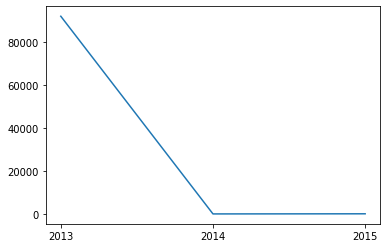

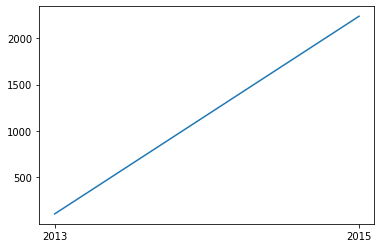

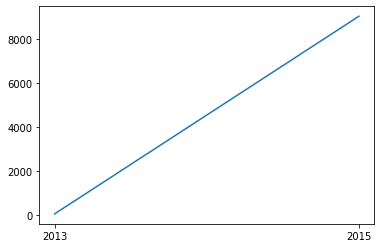

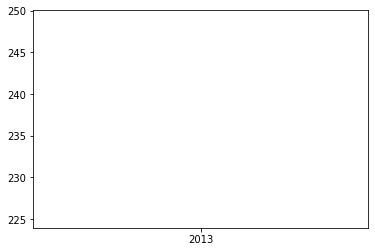

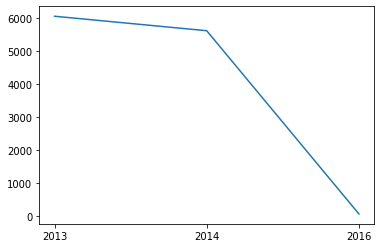

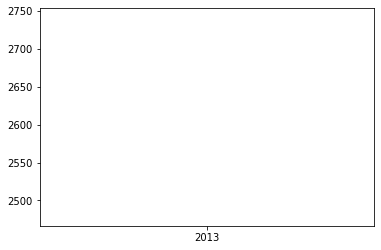

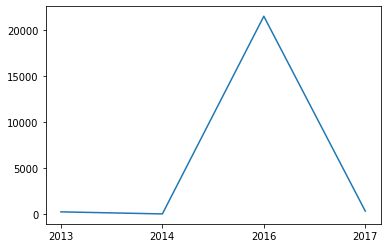

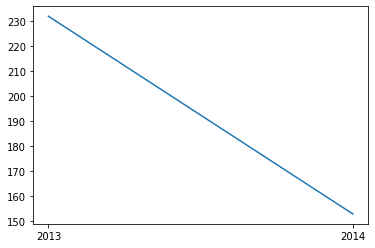

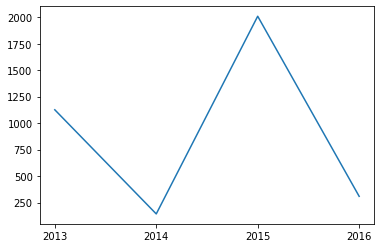

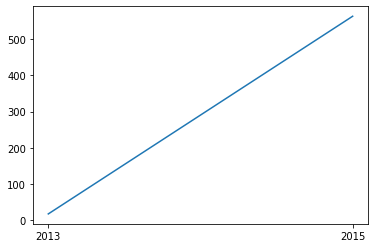

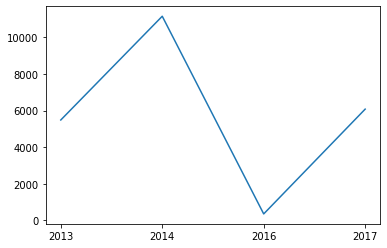

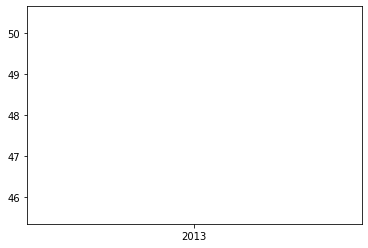

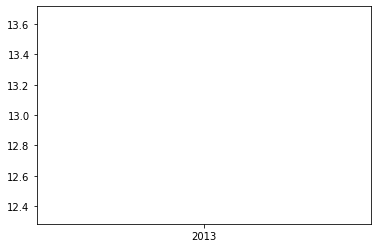

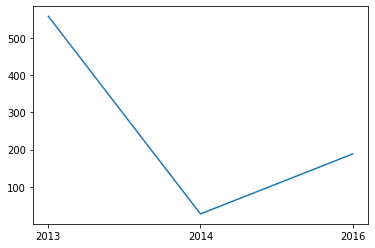

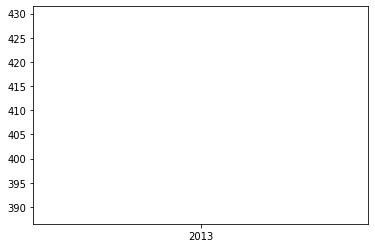

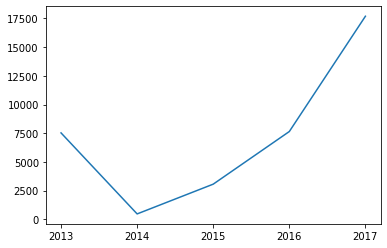

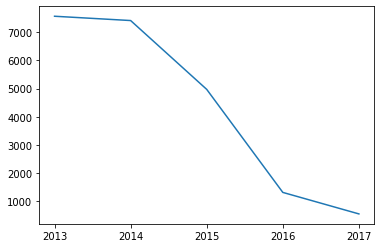

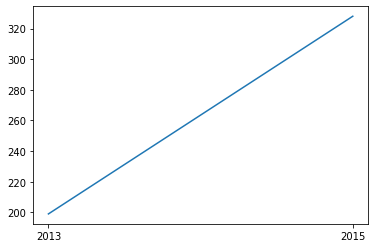

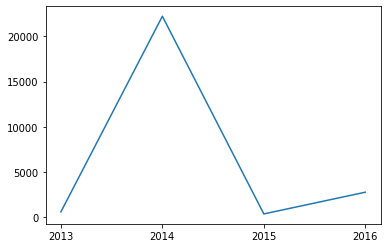

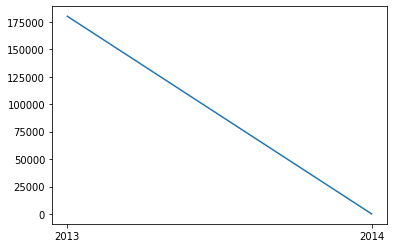

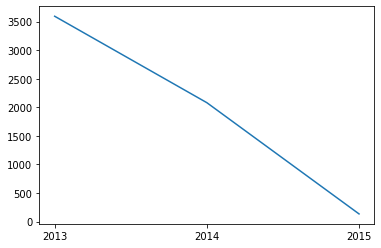

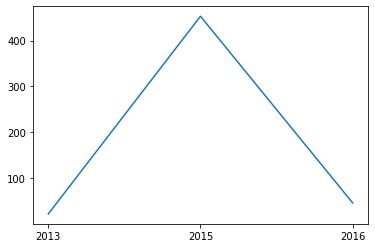

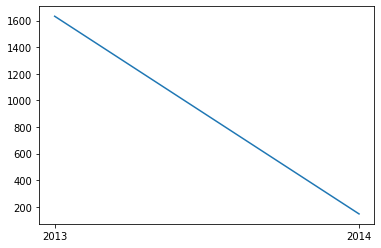

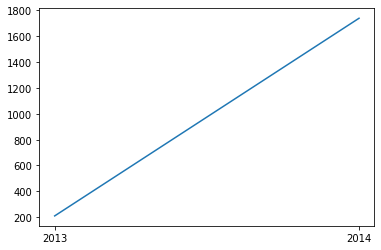

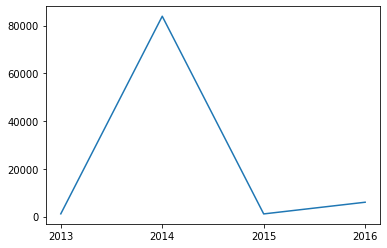

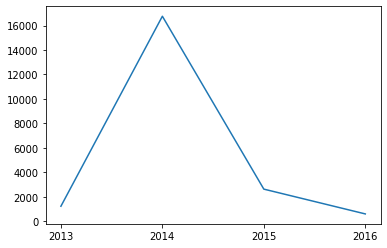

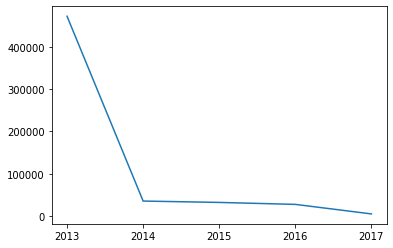

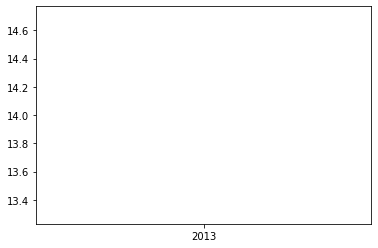

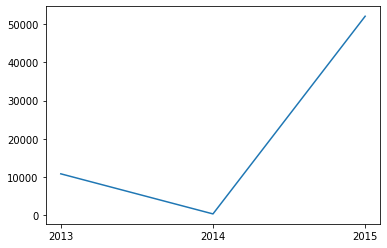

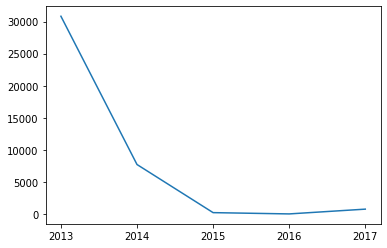

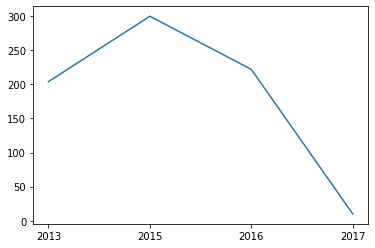

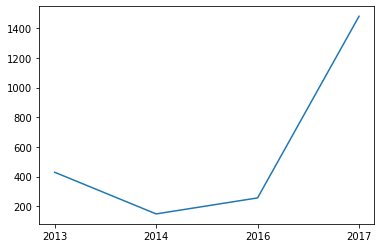

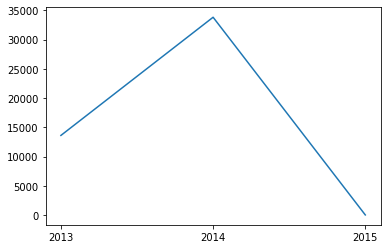

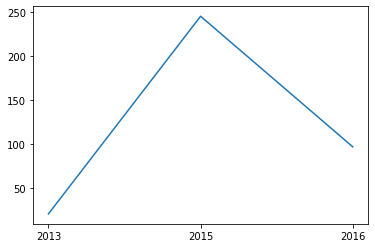

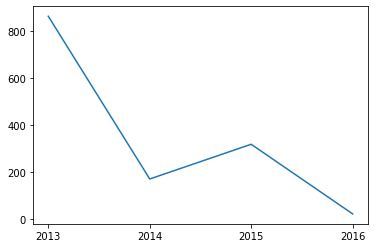

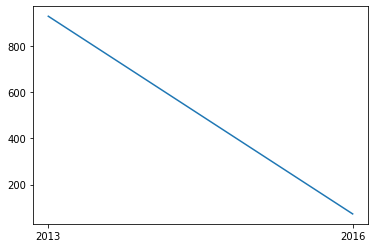

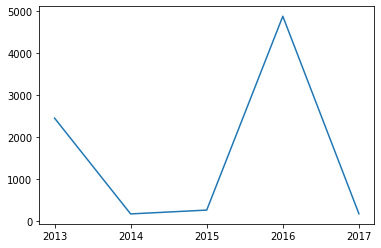

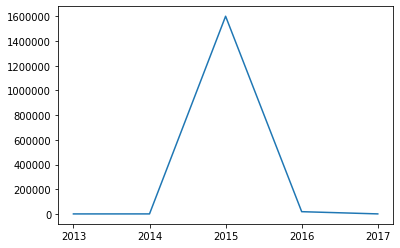

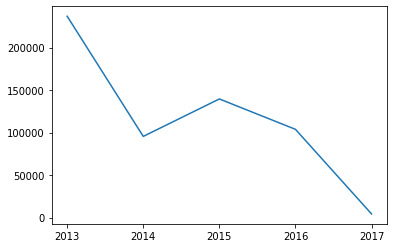

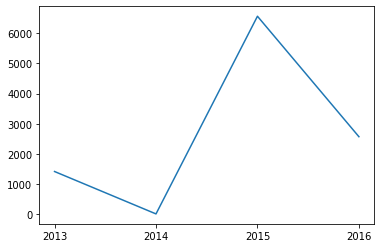

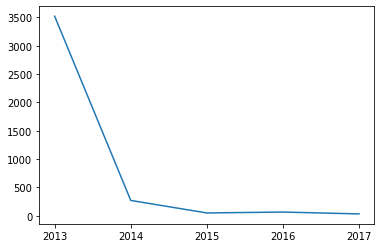

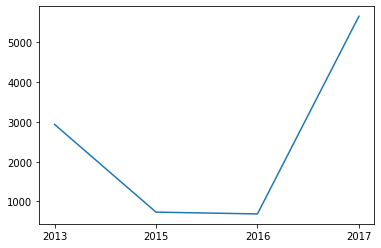

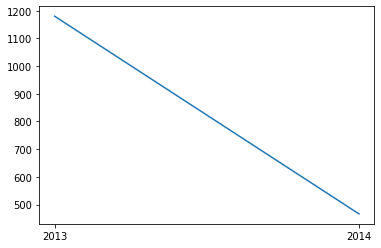

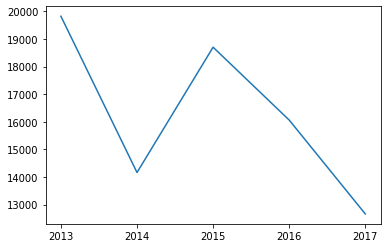

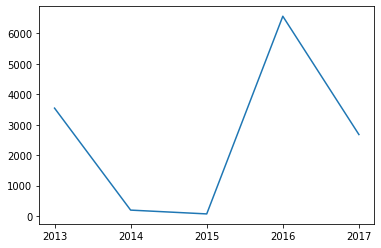

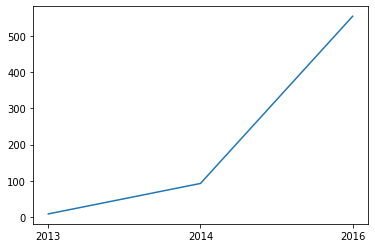

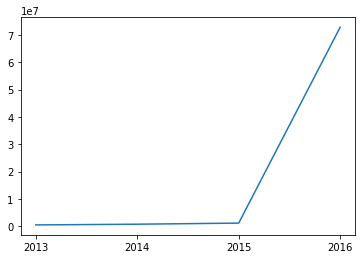

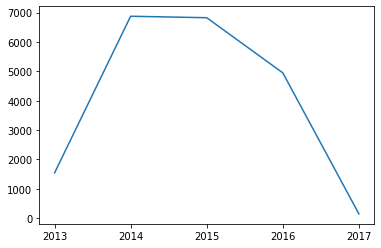

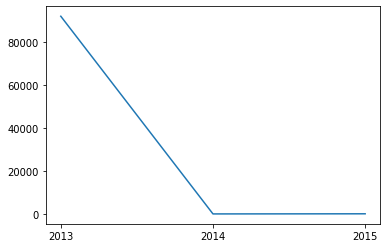

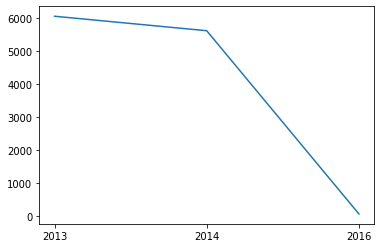

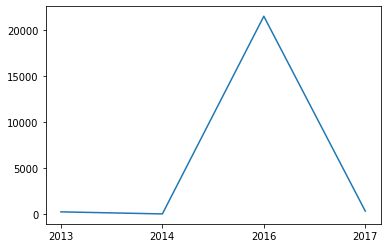

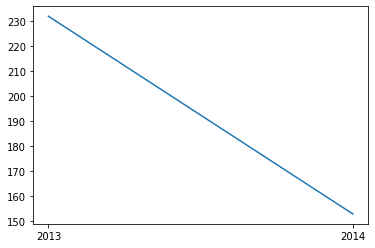

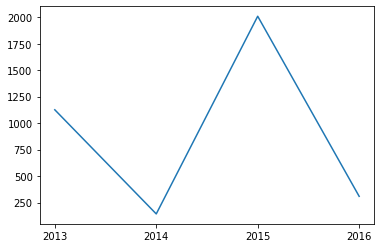

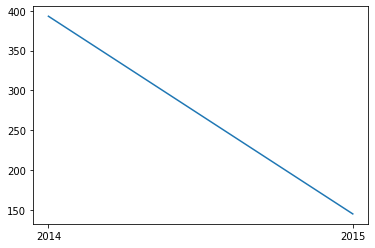

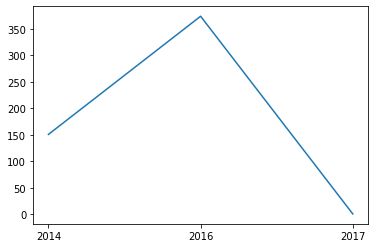

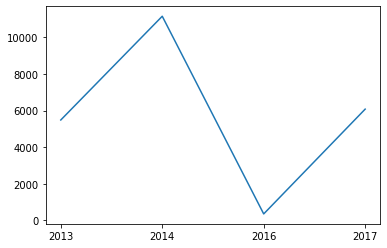

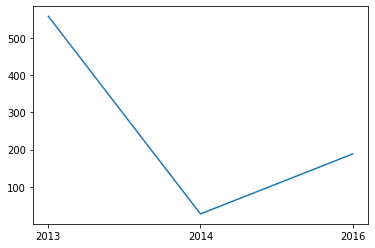

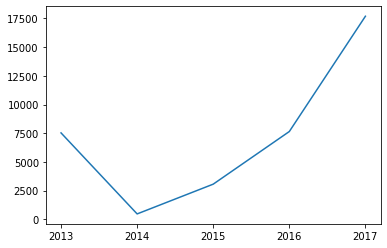

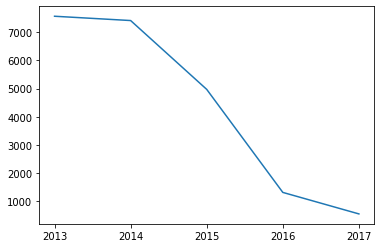

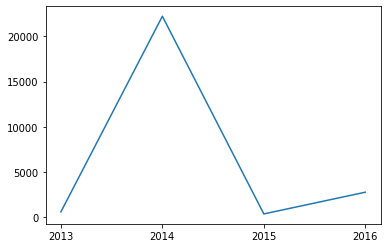

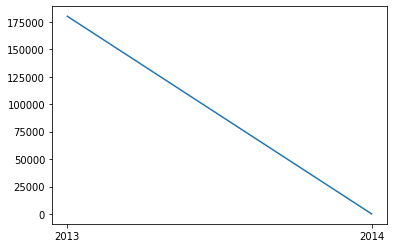

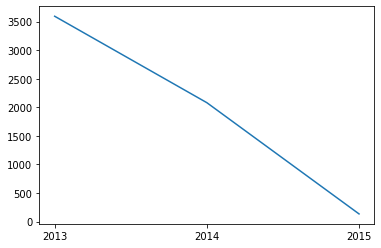

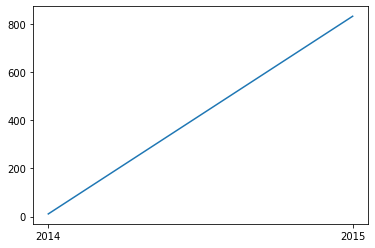

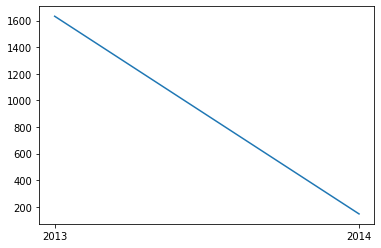

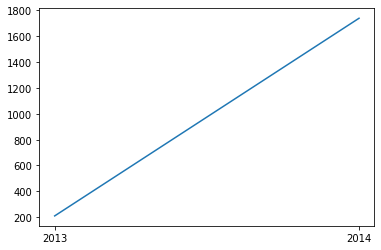

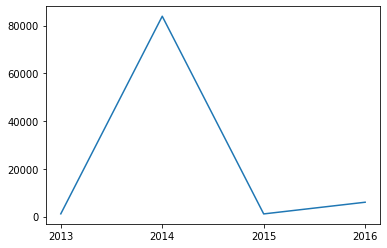

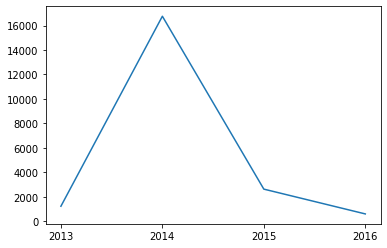

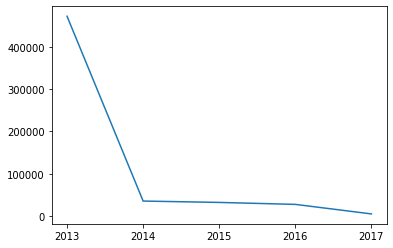

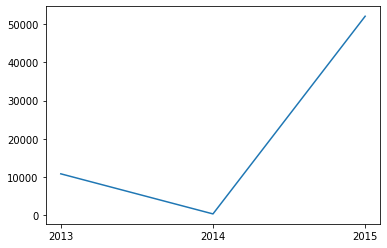

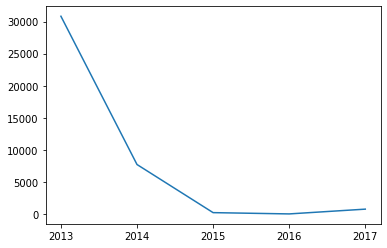

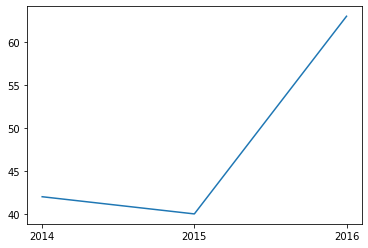

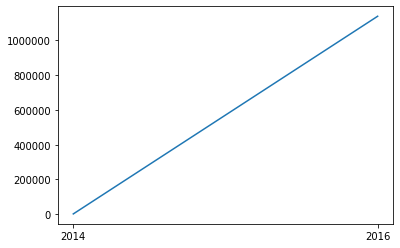

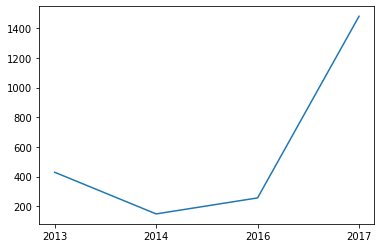

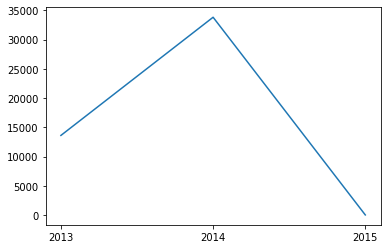

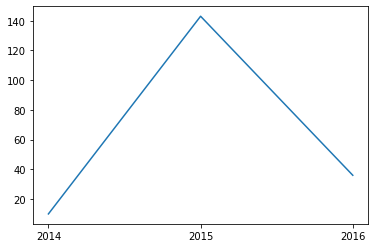

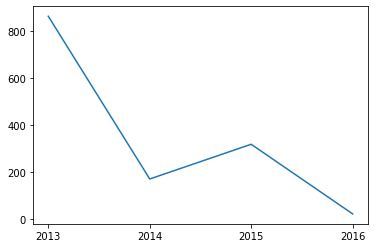

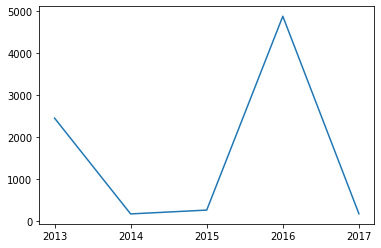

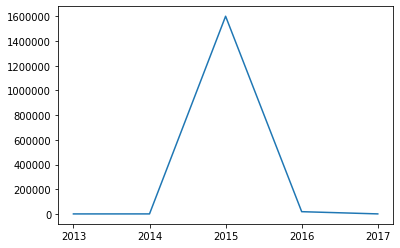

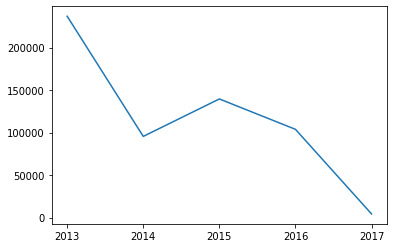

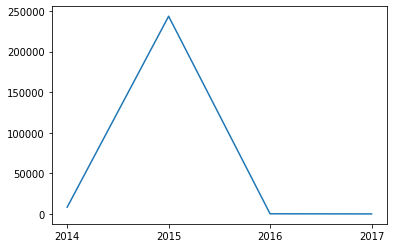

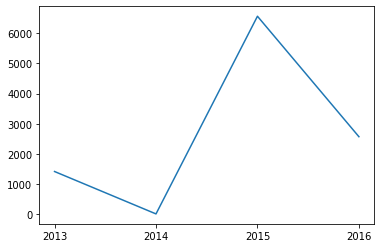

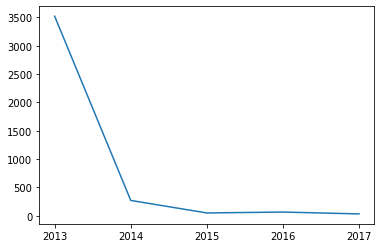

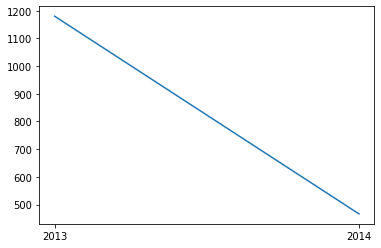

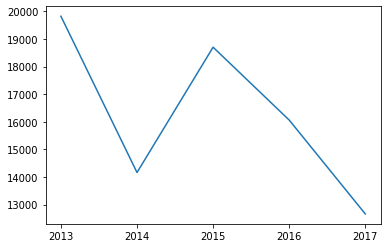

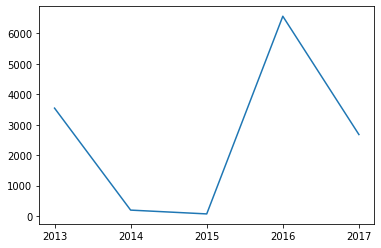

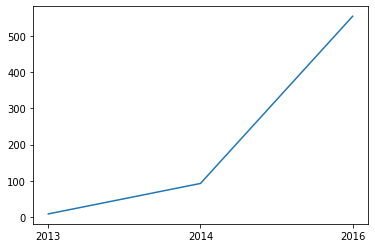

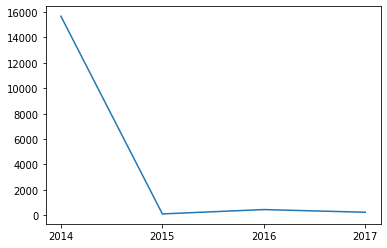

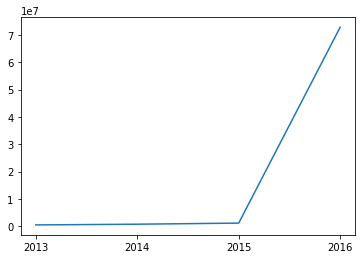

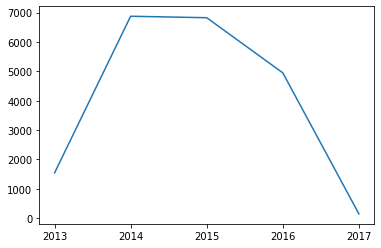

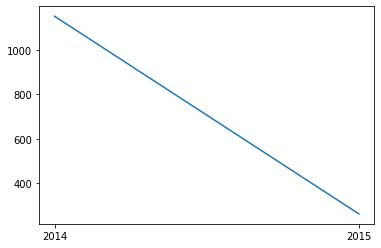

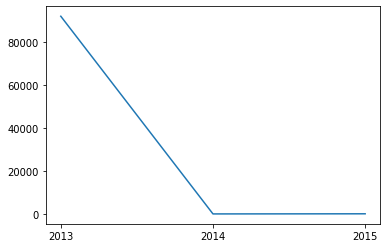

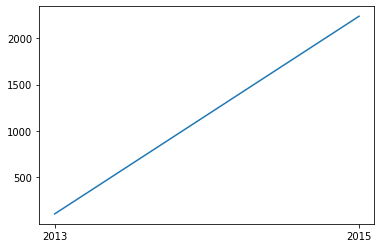

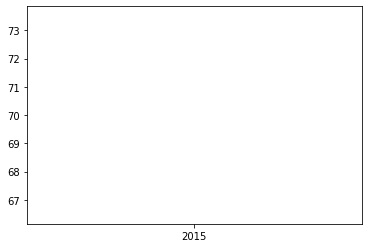

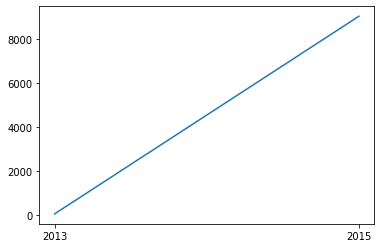

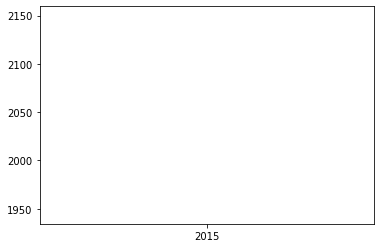

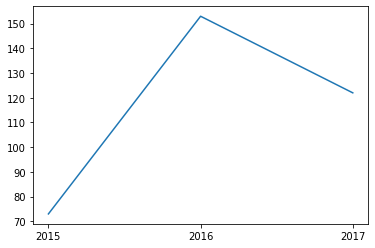

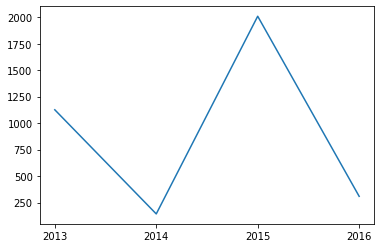

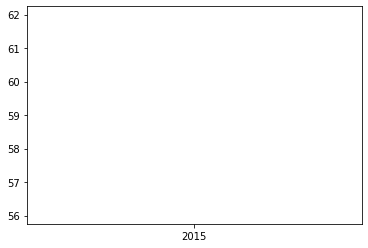

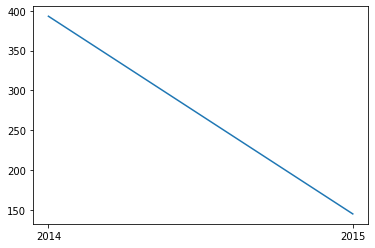

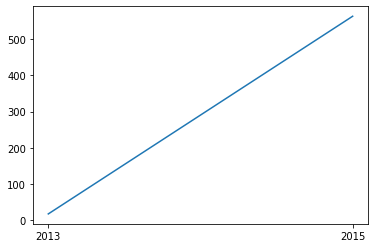

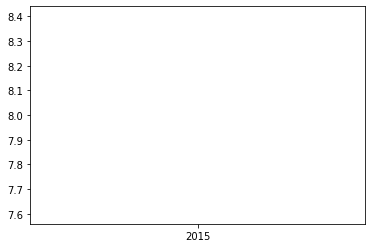

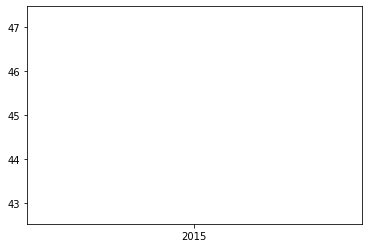

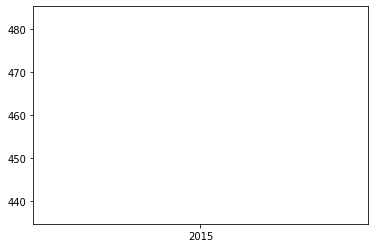

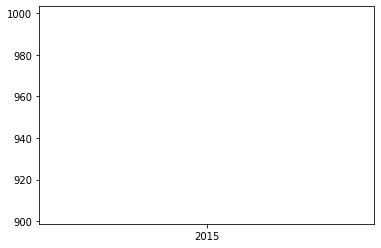

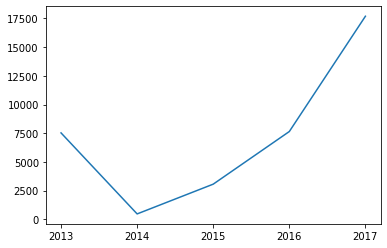

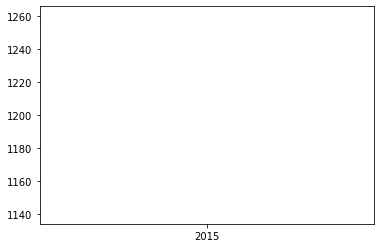

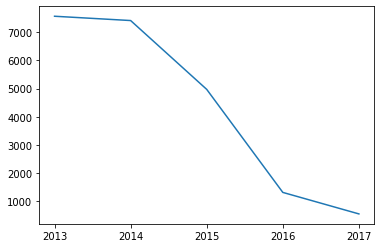

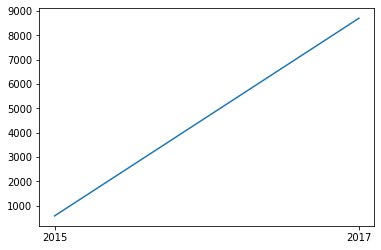

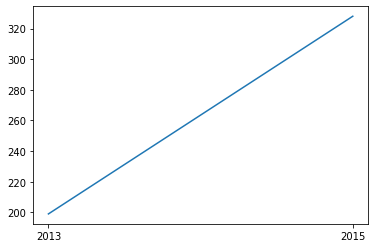

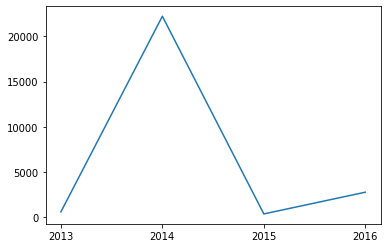

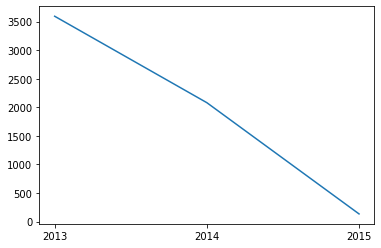

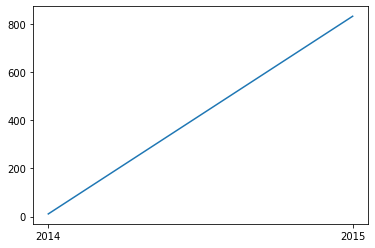

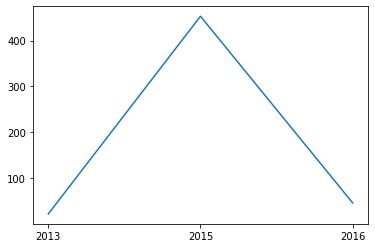

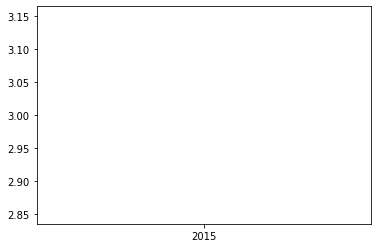

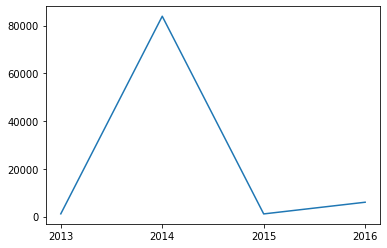

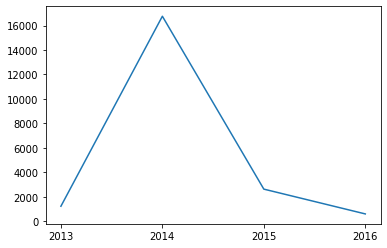

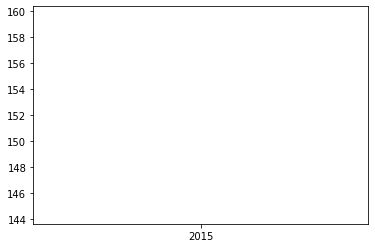

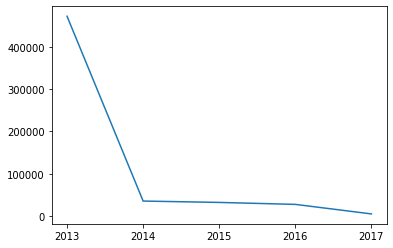

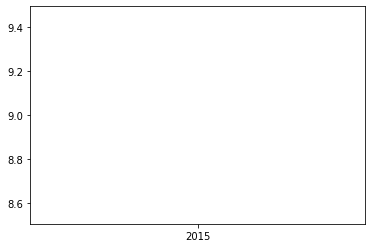

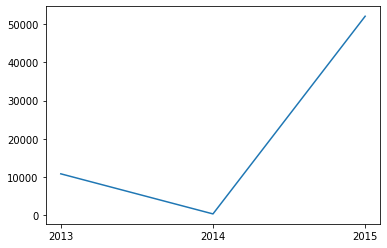

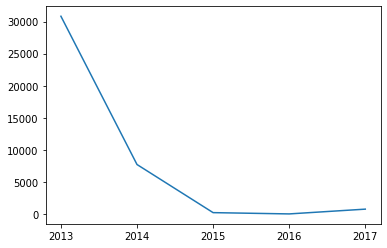

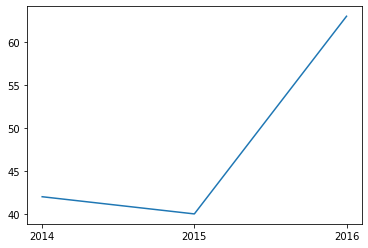

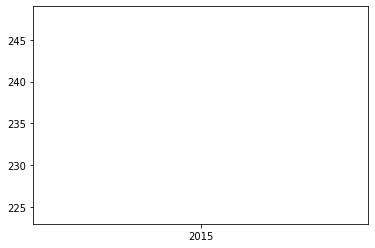

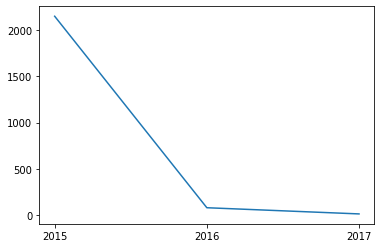

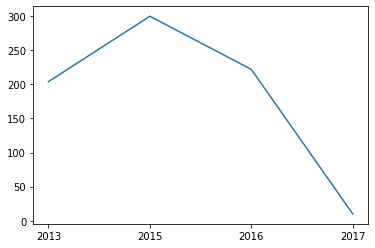

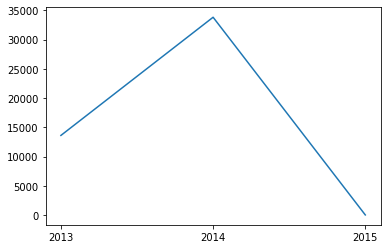

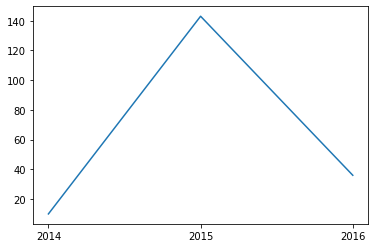

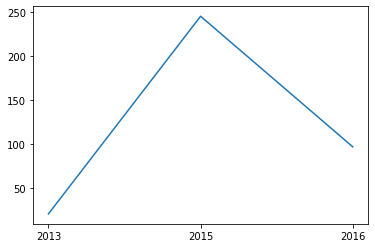

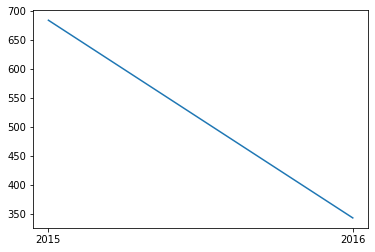

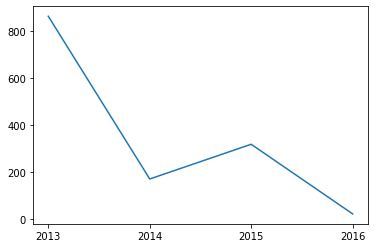

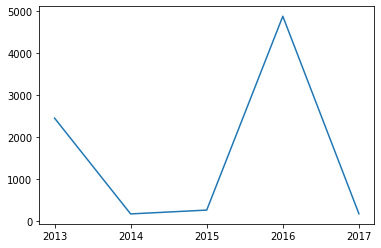

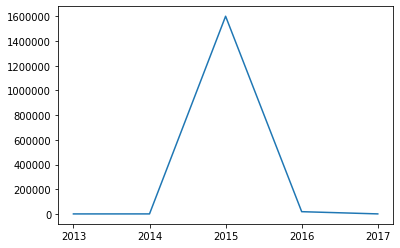

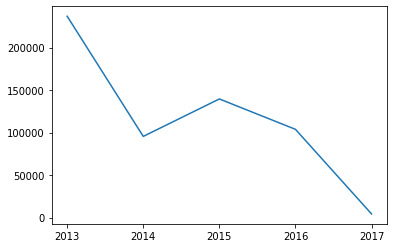

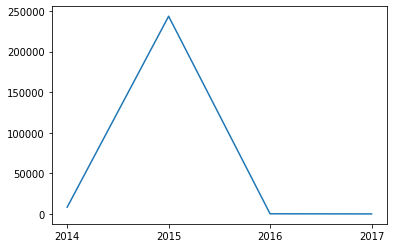

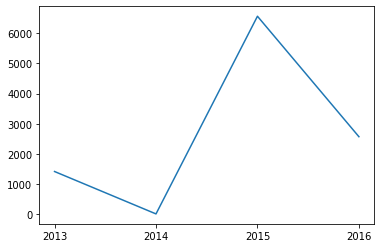

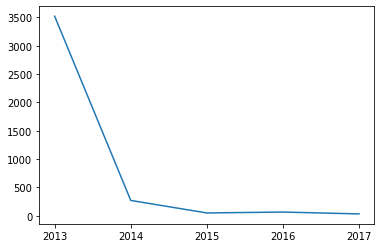

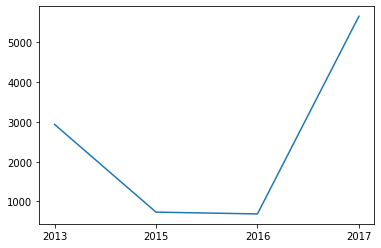

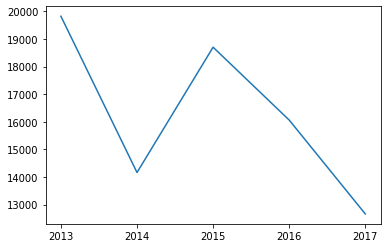

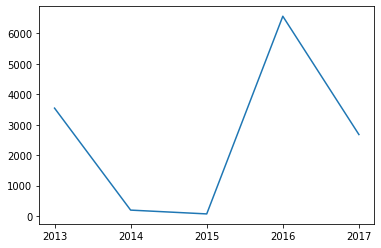

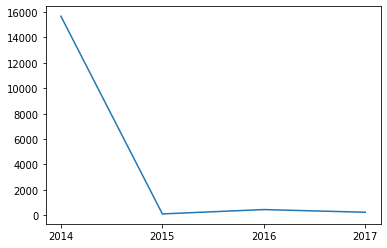

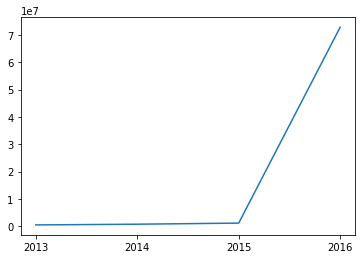

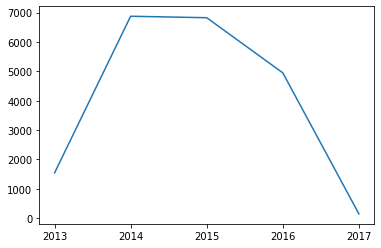

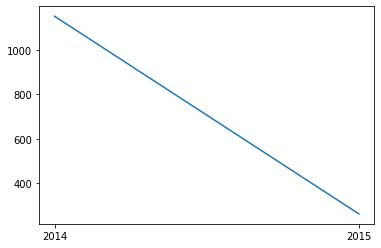

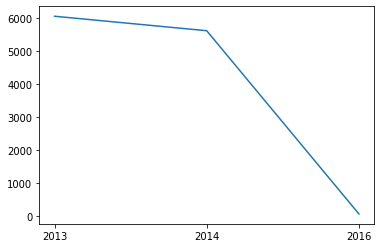

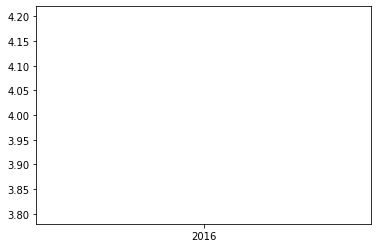

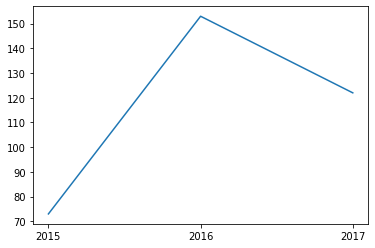

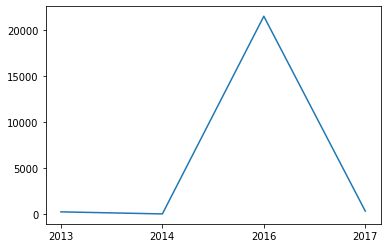

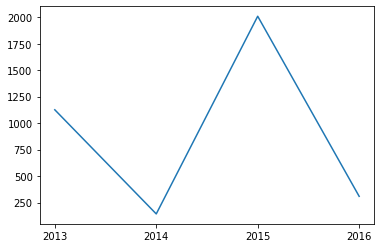

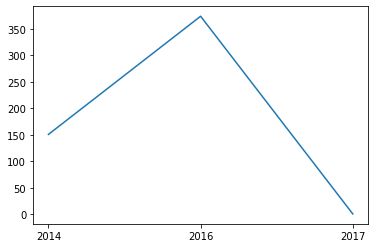

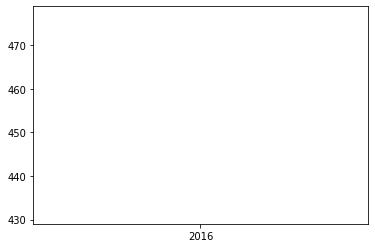

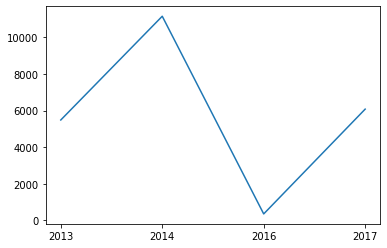

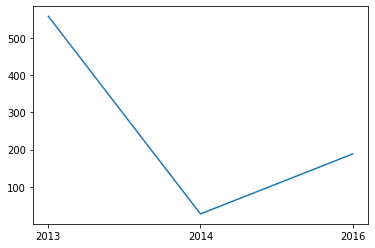

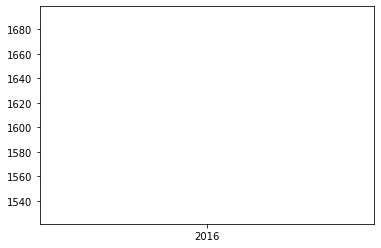

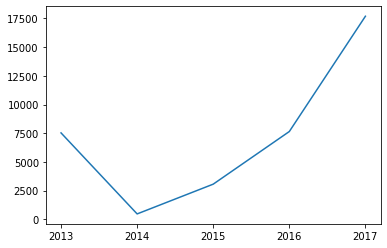

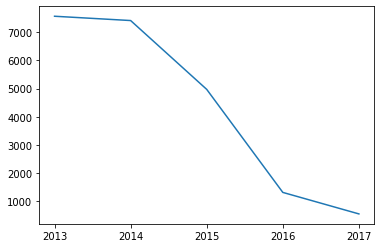

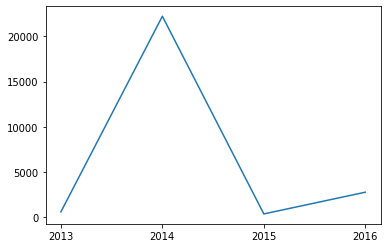

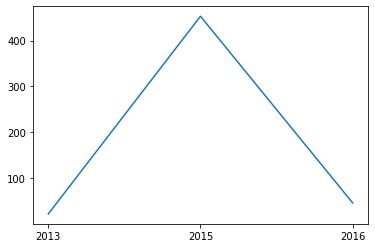

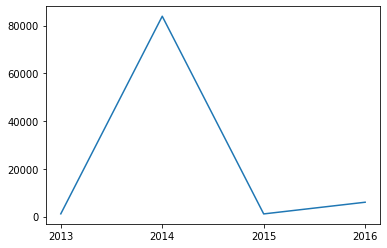

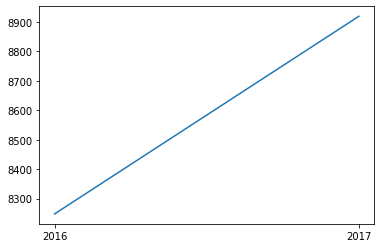

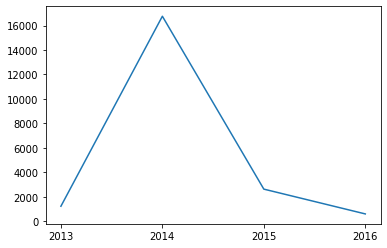

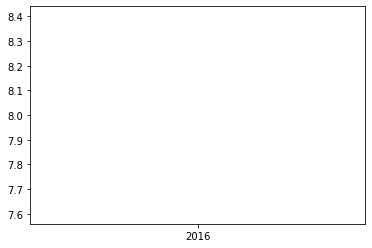

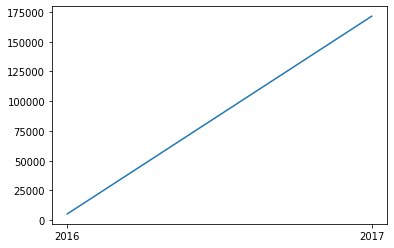

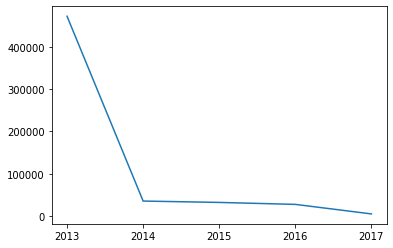

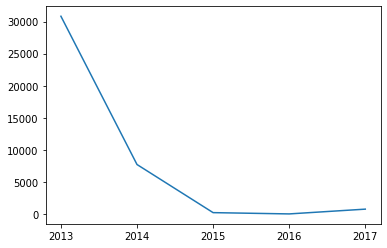

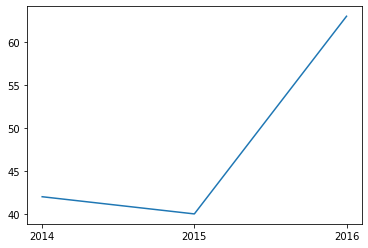

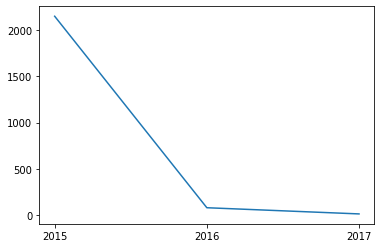

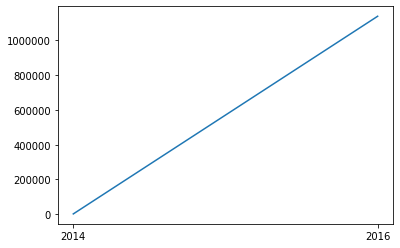

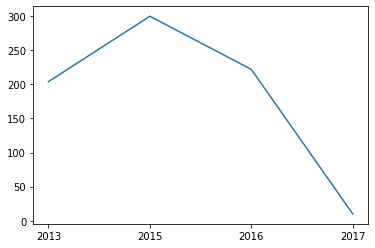

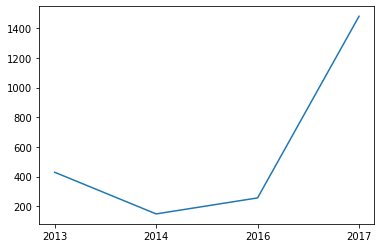

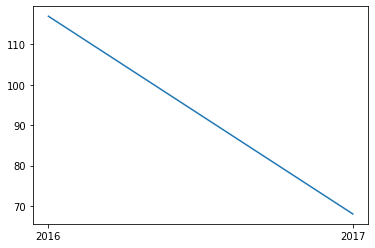

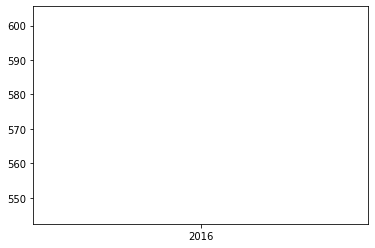

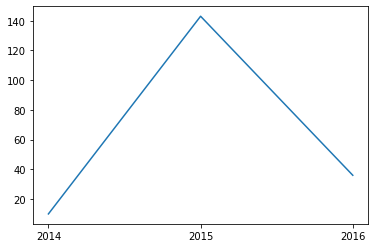

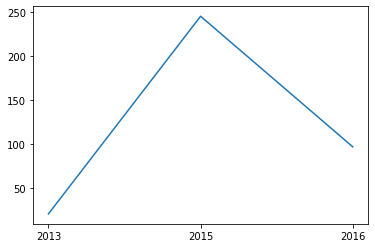

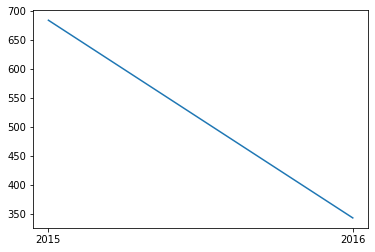

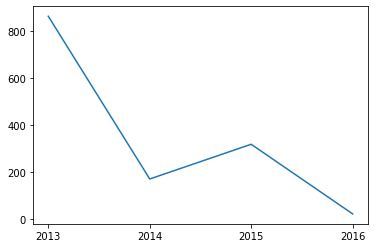

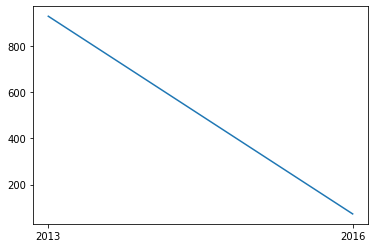

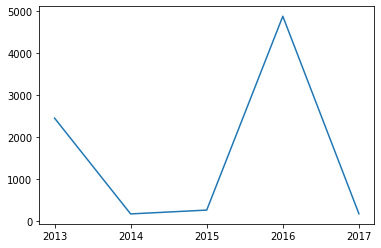

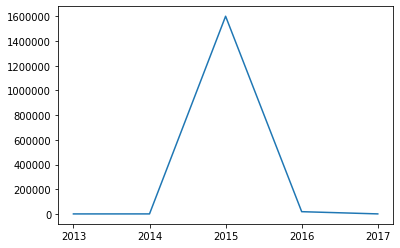

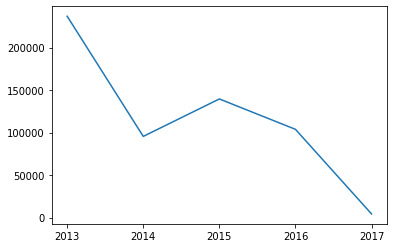

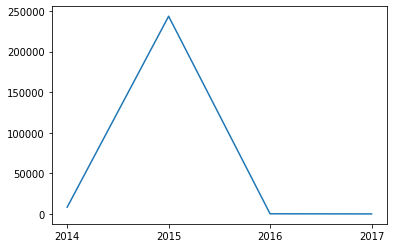

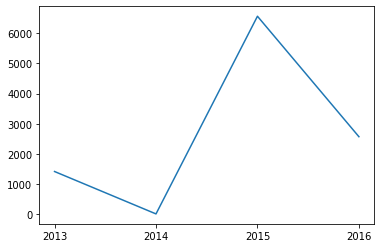

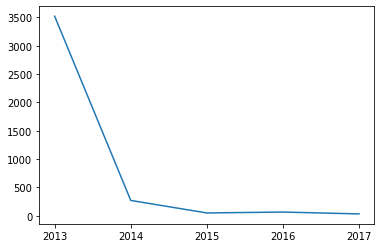

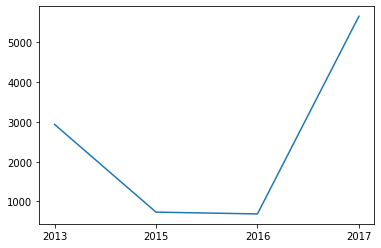

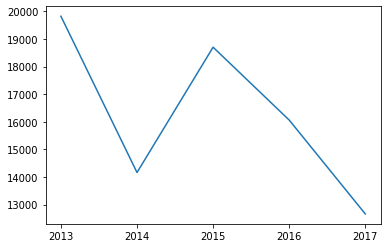

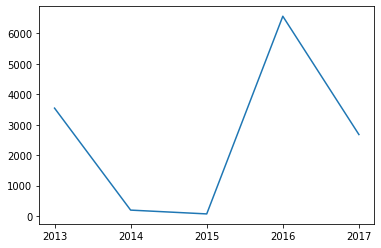

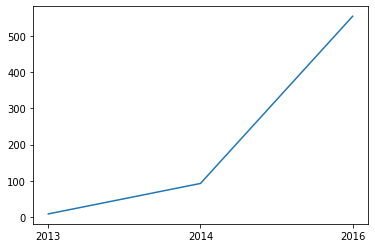

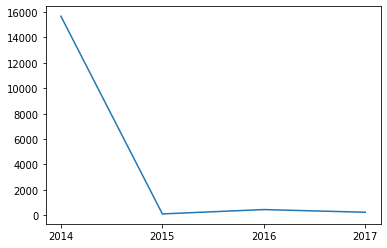

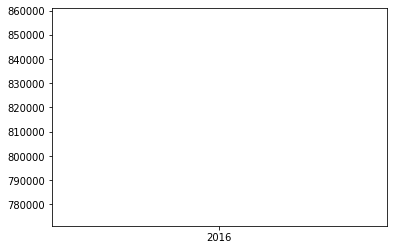

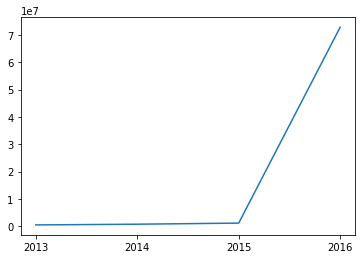

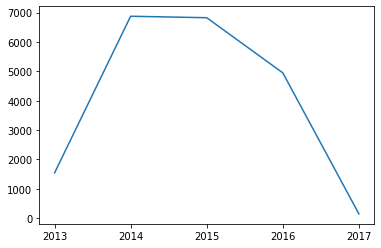

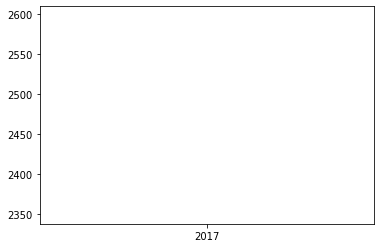

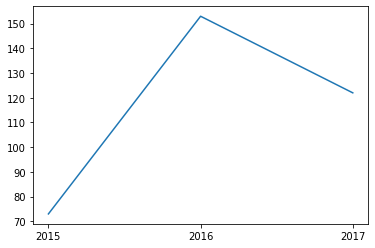

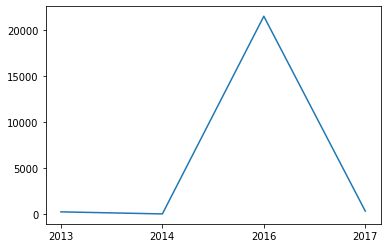

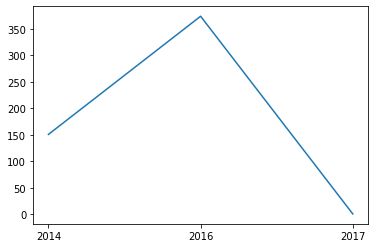

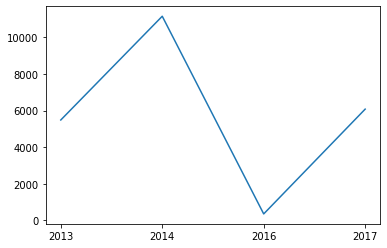

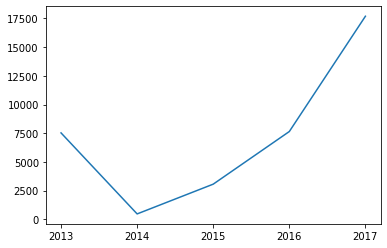

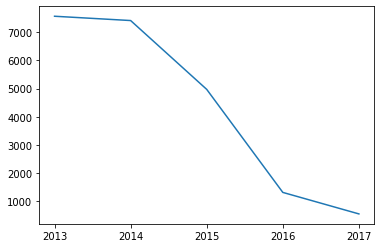

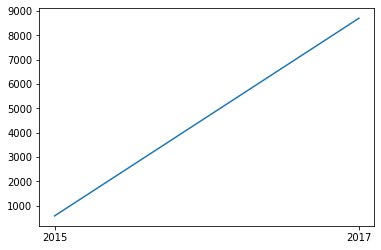

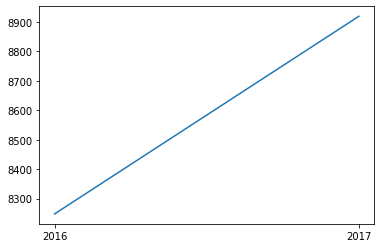

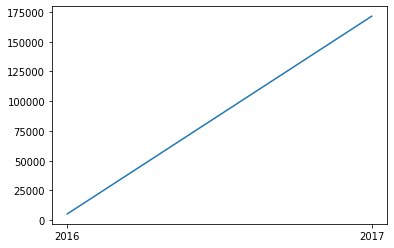

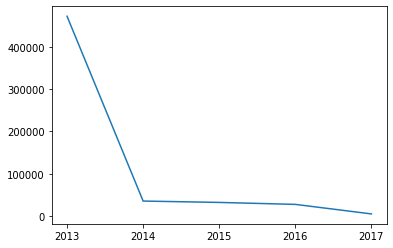

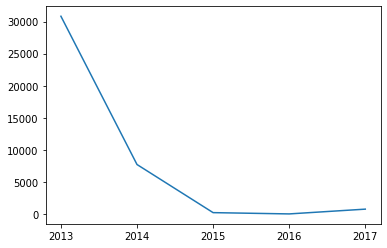

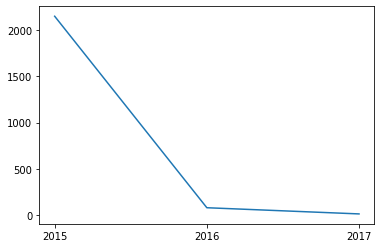

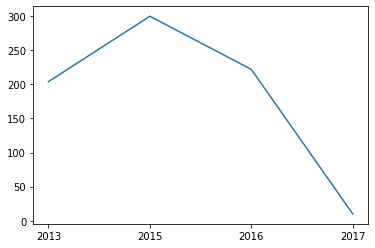

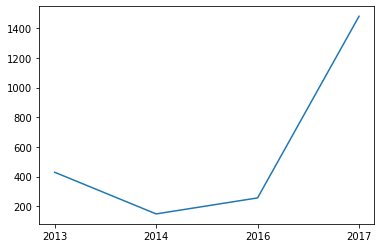

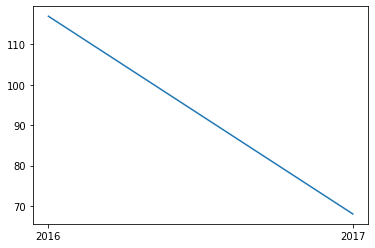

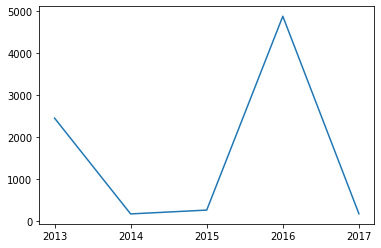

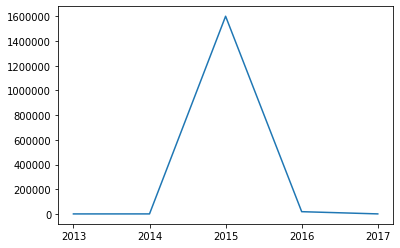

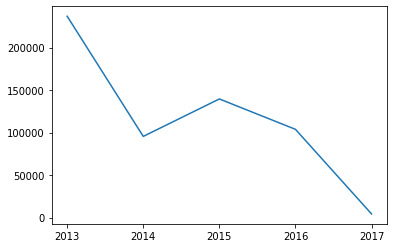

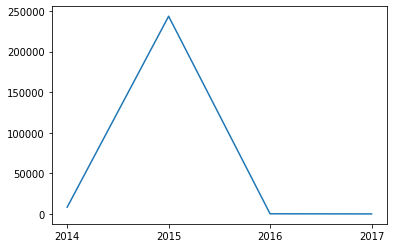

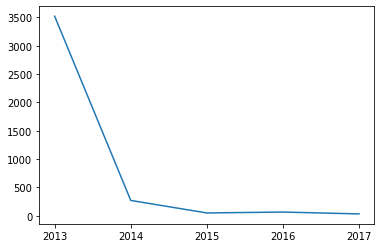

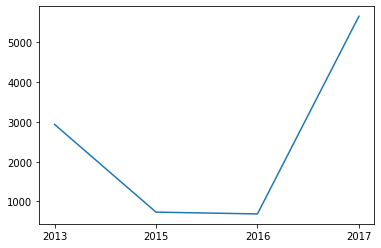

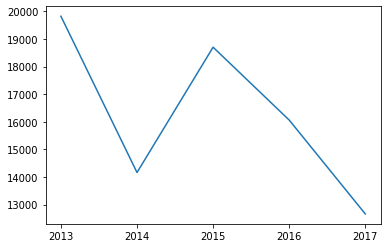

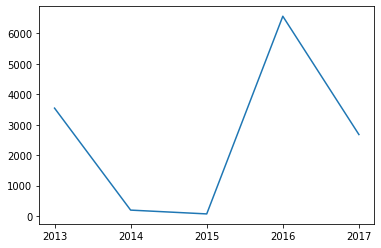

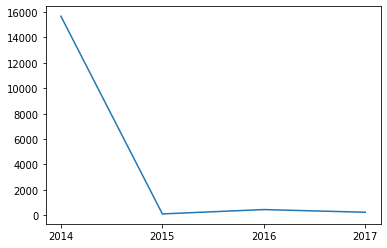

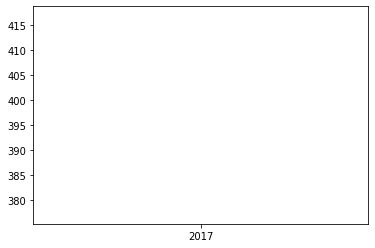

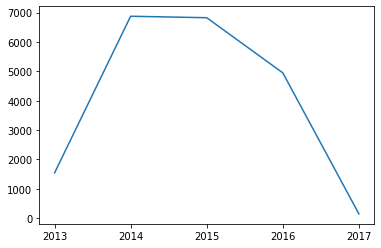

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [244]:
'''
Module to perform analysis on PHILLIPSL
Steps-
1. Create a small dataset for PHILLIPS supplier, 
    the entire dataset is too big, so for analysis
    puropose I decided to create a datframe with small
    chunk pf data.
2. Check trends of customers who are procuring from
    PHILLIPSL.
'''

# Read Module
os.chdir('/Users/Ra/Desktop/on_semi_ds/data/RawData/')
trans_columns = ["id","Year","Customer Segment","Channel","CustomerID",
                 "Order No","Orders","Sales","SKU No","Supplier",
                 "Order Date","Month"]
trans_ph_df = pd.DataFrame(columns = trans_columns)
my_file = open('Trans.csv')

i = 0
local_cntr = 0
for line in my_file:
#    if i == 40000:
#        break
    if i != 0:
        line = line.replace('"', '')
        l = line.split(',')
        if l[9] == 'PHILIPSL':
            if local_cntr == 1000:
                break
            trans_ph_df.loc[local_cntr] = l
            local_cntr += 1
    i += 1
    
# Data Wrangling and cleaning
# sort the data based on year
trans_ph_df = trans_ph_df.sort_values('Year')
# Convert the Month into integer
trans_ph_df['total_amt'] = 0
for i in range(1, len(trans_ph_df)):
    trans_ph_df['Month'][i] = int(trans_ph_df['Month'][i])
    # Create total amount column by multiplying per unit cost.
    # with toatl orders.
    trans_ph_df['total_amt'][i] = int(trans_ph_df['Orders'][i]) * float(trans_ph_df['Sales'][i])

# Create new aggegate dataframe with pertinent columns.
agg_df = pd.DataFrame(columns = ['Year', 'id', 'amount'])
agg_df = trans_ph_df.groupby(['Year', 'CustomerID']).total_amt.sum().to_frame('Total_Sale').reset_index()

# Plot to understand the trend
for customers in agg_df['CustomerID']:
    financial_year = []
    total_sale = []
    for i in range(0, len(agg_df)):
        if agg_df['CustomerID'][i] == customers:
            financial_year.append(agg_df['Year'][i])
            total_sale.append(agg_df['Total_Sale'][i])
    plot(financial_year, total_sale)
    show()

# creating the tagged dataframe
tagged_df = pd.DataFrame(index=agg_df.index, columns = ['customer_id', 'median', 'curr_year_percentage', 'tag'])
tagged_df['tag'] = 'No Value'
idx = 0
for customers in agg_df['CustomerID']:
    curr_year = 0
    percentage = []
    init_store = []
    for i in range(0, len(agg_df)):
        if agg_df['CustomerID'][i] == customers:
            init_store.append(agg_df['Total_Sale'][i])
    
    for i in range(1, len(init_store)):
        temp = ((init_store[i] - init_store[i - 1]) / init_store[i - 1]) * 100
        percentage.append(temp)
    
    ln = len(percentage) - 1
    if ln >= 0:
        curr_year = percentage[ln]
        
    tagged_df['customer_id'][idx] = customers
    tagged_df['median'][idx] = median(percentage)
    tagged_df['curr_year_percentage'][idx] = curr_year
    idx += 1

tagged_df.dropna(inplace = True)
tagged_df.reset_index(drop = True, inplace = True)

# Tag the customer ids based on anlysis
for i in range(0, len(tagged_df)):
    if tagged_df['median'][i] > 0 and tagged_df['curr_year_percentage'][i] < 0:
        tagged_df['tag'][i] = 'high focus'
    elif tagged_df['median'][i] > 0 and tagged_df['curr_year_percentage'][i] > 0 and tagged_df['curr_year_percentage'][i] < tagged_df['median'][i]:
        tagged_df['tag'][i] = 'medium focus'
    elif tagged_df['median'][i] < 0 and tagged_df['curr_year_percentage'][i] > 0 and tagged_df['curr_year_percentage'][i] > tagged_df['median'][i]:
        tagged_df['tag'][i] = 'keep track'
    else:
        tagged_df['tag'][i] = 'safe'

tagged_df

In [294]:
'''
Final module to find customer
'''
# Read Module
os.chdir('/Users/Ra/Desktop/on_semi_ds/data/RawData/')
trans_columns = ["id","Year","Customer Segment","Channel","CustomerID","Order No","Orders","Sales","SKU No","Supplier","Order Date","Month"]
trans_no_phl_df = pd.DataFrame(columns = trans_columns)
my_file = open('Trans.csv')

i = 0
local_cntr = 0
for line in my_file:
    if i == 10000:
        break
    if i != 0:
        line = line.replace('"', '')
        l = line.split(',')
        if l[9] != 'PHILIPSLa':
            trans_no_phl_df.loc[local_cntr] = l
            local_cntr += 1
    i += 1

# store the sku no of items supplied by phillips
items_phillips = set()
for items in trans_ph_df['SKU No']:
    items_phillips.add(items)

# Create an interim df with items supplied by phillips
similar_items_df = pd.DataFrame(index = trans_no_phl_df.index, columns = trans_columns)
for i in range(0, len(trans_no_phl_df)):
    if trans_no_phl_df['SKU No'][i] in items_phillips:
        similar_items_df.loc[i] = trans_no_phl_df.loc[i]
similar_items_df.dropna(inplace = True)
similar_items_df.reset_index(drop = True, inplace = True)

# Data Wrangling and cleaning
# sort the data based on year
similar_items_df = similar_items_df.sort_values('Year')
# Convert the Month into integer
similar_items_df['total_amt'] = 0
for i in range(1, len(similar_items_df)):
    similar_items_df['Month'][i] = int(similar_items_df['Month'][i])
    # Create total amount column by multiplying per unit cost.
    # with toatl orders.
    similar_items_df['total_amt'][i] = int(similar_items_df['Orders'][i]) * float(similar_items_df['Sales'][i])

# Create new aggegate dataframe with pertinent columns.
#cust_target_agg_df = pd.DataFrame(columns = ['Year', 'id', 'amount'])
cust_target_agg_df = similar_items_df.groupby(['Year', 'CustomerID', 'Supplier', 'SKU No']).total_amt.sum().to_frame('Total_Sale').reset_index()

# add composite key- concat(CustomerID, Supplier)
cust_target_agg_df['c_key'] = 'N/A'
for i in range(0, len(cust_target_agg_df)):
    cust_target_agg_df['c_key'][i] = cust_target_agg_df['CustomerID'][i] + cust_target_agg_df['Supplier'][i]
    
# creating the tagged dataframe
cust_target_tagged_df = pd.DataFrame(index=cust_target_agg_df.index, columns = ['customer_id', 'c_key', 'median', 'curr_year_percentage', 'tag'])
cust_target_tagged_df['tag'] = 'No Value'
idx = 0
for customers in cust_target_agg_df['CustomerID']:
    curr_year = 0
    percentage = []
    init_store = []
    for i in range(0, len(cust_target_agg_df)):
        if cust_target_agg_df['CustomerID'][i] == customers:
            init_store.append(cust_target_agg_df['Total_Sale'][i])
            cust_target_tagged_df['c_key'][i] = cust_target_agg_df['c_key'][i]
    
    for i in range(1, len(init_store)):
        temp = ((init_store[i] - init_store[i - 1]) / init_store[i - 1]) * 100
        percentage.append(temp)
    
    ln = len(percentage) - 1
    if ln >= 0:
        curr_year = percentage[ln]
    # Drop the na values and reset index
    cust_target_tagged_df.dropna(subset=['c_key'], inplace = True)
    cust_target_tagged_df.reset_index(drop = True, inplace = True)
    
    cust_target_tagged_df['customer_id'][idx] = customers
    cust_target_tagged_df['median'][idx] = median(percentage)
    cust_target_tagged_df['curr_year_percentage'][idx] = curr_year
    idx += 1

# Tag the customer ids based on anlysis
for i in range(0, len(cust_target_tagged_df)):
    if cust_target_tagged_df['median'][i] > 0 and cust_target_tagged_df['curr_year_percentage'][i] < 0:
        cust_target_tagged_df['tag'][i] = 'high focus'
    elif cust_target_tagged_df['median'][i] > 0 and cust_target_tagged_df['curr_year_percentage'][i] > 0 and cust_target_tagged_df['curr_year_percentage'][i] < cust_target_tagged_df['median'][i]:
        cust_target_tagged_df['tag'][i] = 'medium focus'
    elif cust_target_tagged_df['median'][i] < 0 and cust_target_tagged_df['curr_year_percentage'][i] > 0 and cust_target_tagged_df['curr_year_percentage'][i] > cust_target_tagged_df['median'][i]:
        cust_target_tagged_df['tag'][i] = 'keep track'
    else:
        cust_target_tagged_df['tag'][i] = 'safe'

cust_target_tagged_df


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in long

,customer_id,c_key,f_key,median,curr_year_percentage,tag
0,10,10PHILIPSL,NaN,235.054,282.609,safe
1,10,10PHILIPSL,NaN,235.054,282.609,safe
2,12,12PHILIPSL,NaN,0.213523,-97.8338,high focus
3,12,12PHILIPSL,NaN,0.213523,-97.8338,high focus
4,12,12PHILIPSL,NaN,0.213523,-97.8338,high focus


In [119]:
for i in range(1, len(trans_df)):
    if trans_df['SKU No'][i] == '1119355':
        print (trans_df.loc[i])

id                      2275
Year                    2013
Customer Segment           I
Channel              Offline
CustomerID                 7
Order No             3491258
Orders                   250
Sales                 269.28
SKU No               1119355
Supplier             KAB+LTG
Order Date          20130912
Month                    9\n
Name: 2275, dtype: object
id                     21208
Year                    2013
Customer Segment           O
Channel              Offline
CustomerID                67
Order No             2809059
Orders                   500
Sales                 347.14
SKU No               1119355
Supplier             KAB+LTG
Order Date          20130115
Month                    1\n
Name: 21208, dtype: object
id                     21557
Year                    2015
Customer Segment           O
Channel              Offline
CustomerID                67
Order No             3656069
Orders                   500
Sales                 329.75
SKU No             

In [34]:
'''
Module to read the Leaf category data.
'''
leaf_df = pd.read_csv('LeafCategory.csv')

In [345]:
leaf_df['LeafCategory'].unique()

array(['EC000005', 'EC000084', 'EC000128', ..., 'EC011984', 'EC011986',
       'EC012172'], dtype=object)

In [36]:
'''
Module to read the Root category data.
'''
root_df = pd.read_csv('RootCategory.csv', engine = 'python')

In [342]:
root_df['RootCategory'].unique()

array([nan, 'Haustechnik', 'Marke', 'Chartst�rmer', 'Kabel & Leitungen',
       'Hagemeyer', 'Lichttechnik', 'Geb�udetechnik', 'Installation',
       'Industriekomponenten', 'Werkzeuge', 'Verteiler',
       'Schalter, Steckdosen, Stecker', 'SAT, DNT, Telefonie'],
      dtype=object)

In [299]:
# Understand segments
trans_no_phl_df['Customer Segment'].unique()

array(['I', 'A', 'U', 'J', 'N', 'P', 'K', 'W', 'V', 'H', 'R'],
      dtype=object)

In [307]:
i_seg_df = pd.DataFrame(index = trans_no_phl_df.index, columns = trans_columns)
a_seg_df = pd.DataFrame(index = trans_no_phl_df.index, columns = trans_columns)
u_seg_df = pd.DataFrame(index = trans_no_phl_df.index, columns = trans_columns)

for i in range(0, len(trans_no_phl_df)):
    if trans_no_phl_df['Customer Segment'][i] == 'I':
        i_seg_df.loc[i] = trans_no_phl_df.loc[i]
    elif trans_no_phl_df['Customer Segment'][i] == 'A':
        a_seg_df.loc[i] = trans_no_phl_df.loc[i]
    elif trans_no_phl_df['Customer Segment'][i] == 'U':
        u_seg_df.loc[i] = trans_no_phl_df.loc[i]

In [308]:
i_seg_df.dropna(inplace = True)
i_seg_df.reset_index(drop = True, inplace = True)

a_seg_df.dropna(inplace = True)
a_seg_df.reset_index(drop = True, inplace = True)

u_seg_df.dropna(inplace = True)
u_seg_df.reset_index(drop = True, inplace = True)

In [339]:
i_seg_df

array(['eCommerce', 'Offline'], dtype=object)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


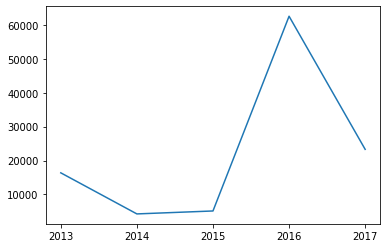

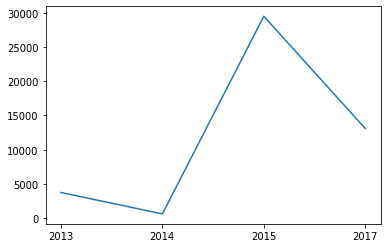

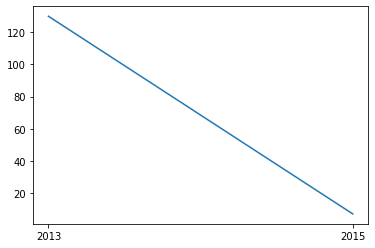

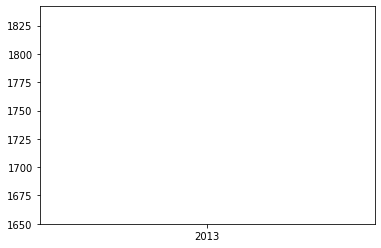

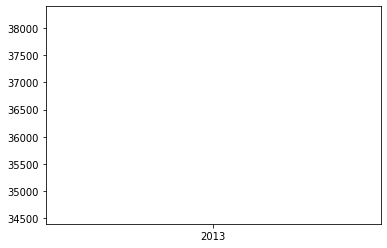

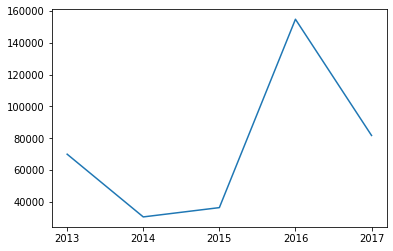

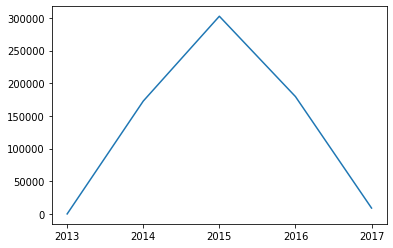

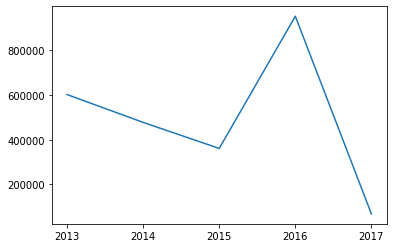

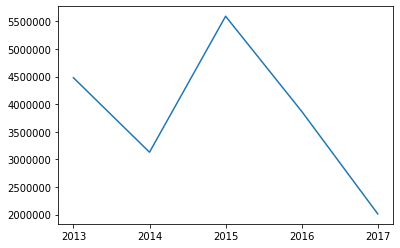

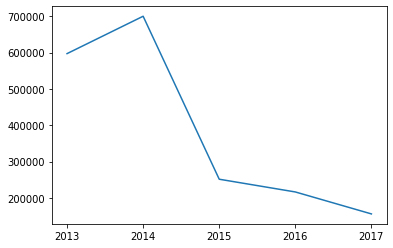

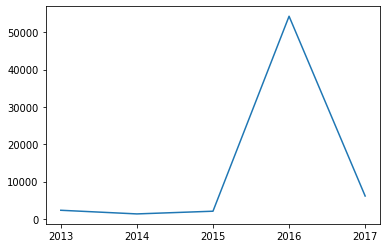

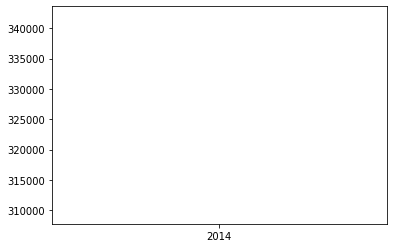

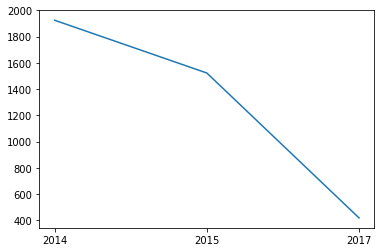

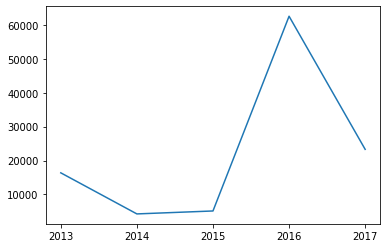

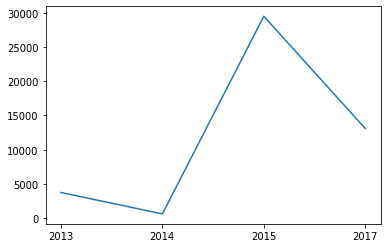

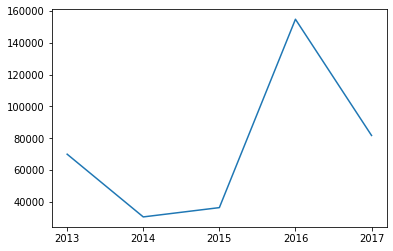

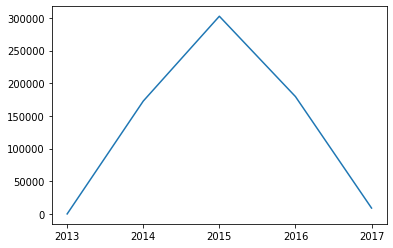

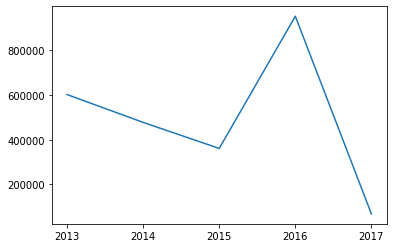

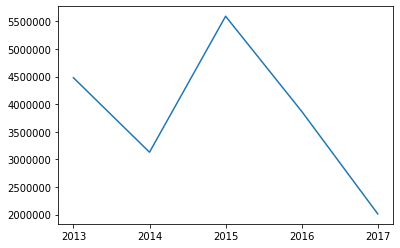

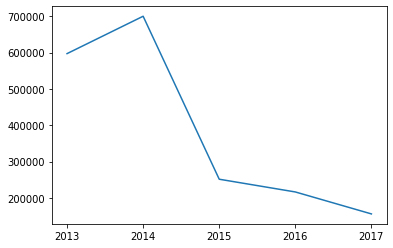

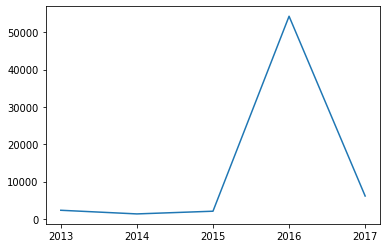

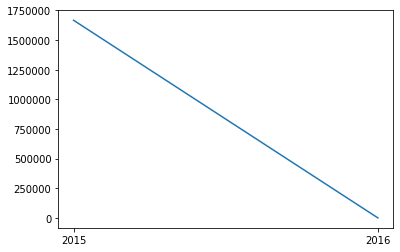

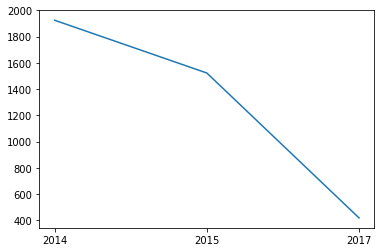

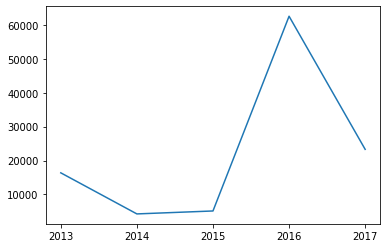

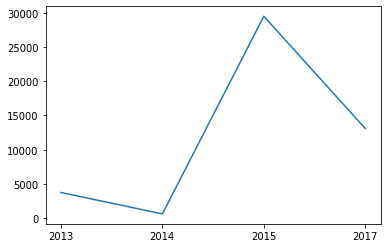

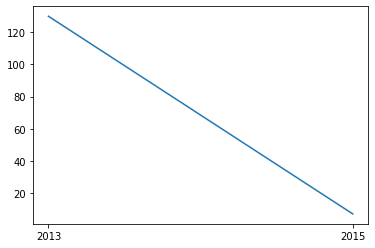

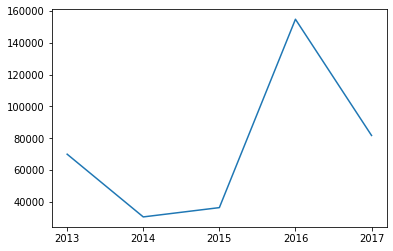

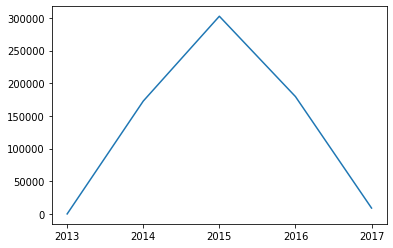

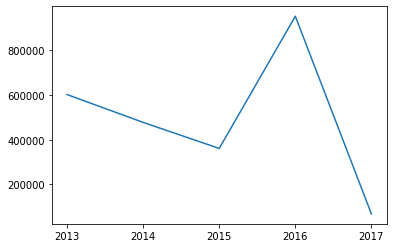

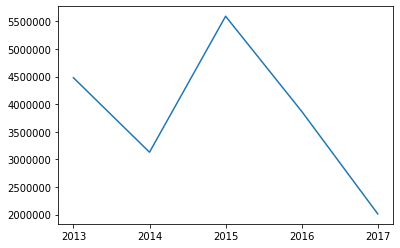

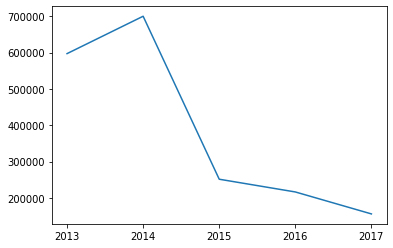

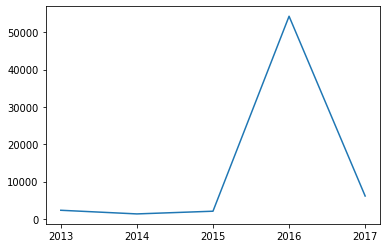

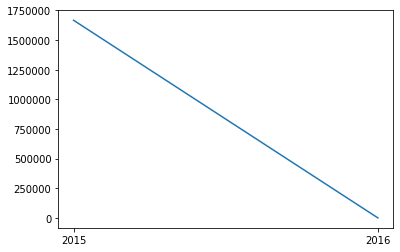

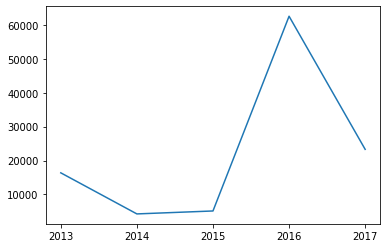

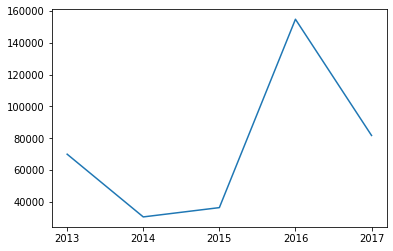

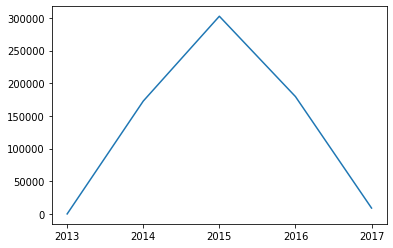

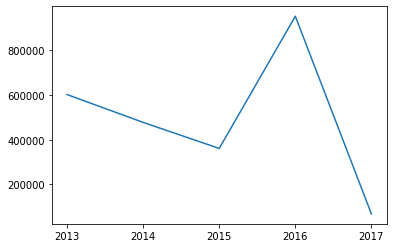

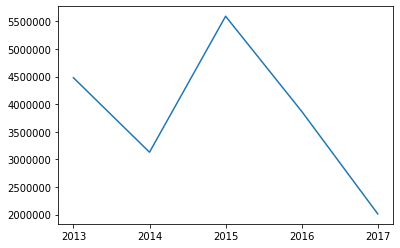

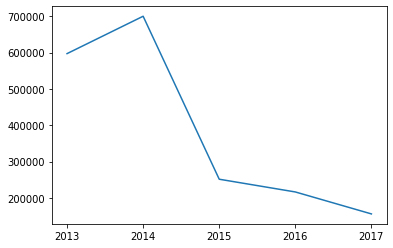

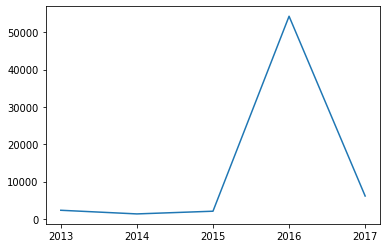

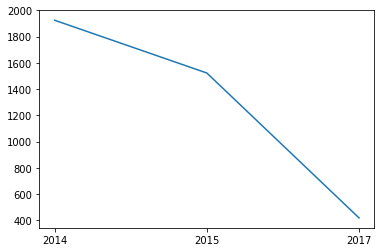

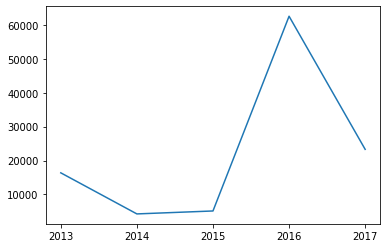

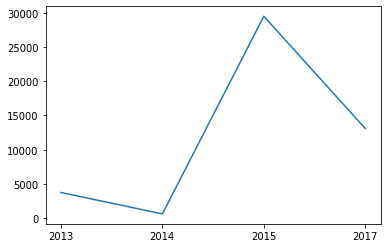

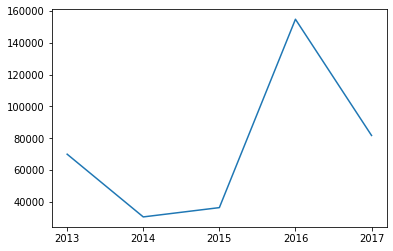

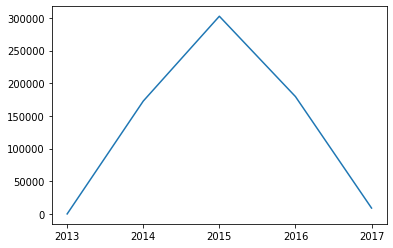

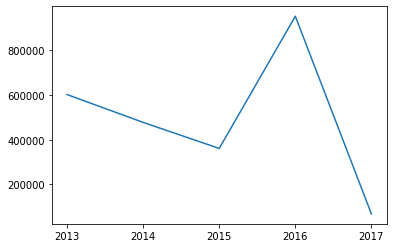

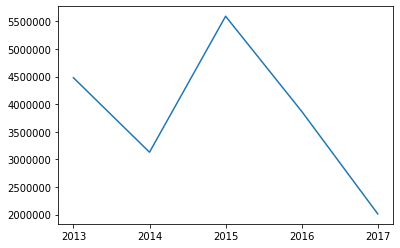

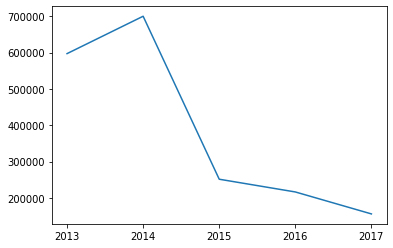

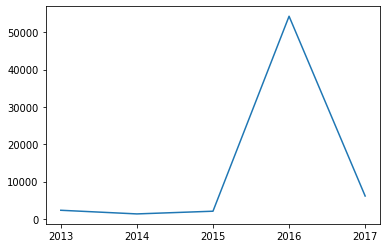

In [351]:
i_seg_df = i_seg_df.sort_values('Year')
# Convert the Month into integer
i_seg_df['total_amt'] = 0
for i in range(1, len(i_seg_df)):
    i_seg_df['Month'][i] = int(i_seg_df['Month'][i])
    # Create total amount column by multiplying per unit cost.
    # with toatl orders.
    i_seg_df['total_amt'][i] = int(i_seg_df['Orders'][i]) * float(i_seg_df['Sales'][i])

# Create new aggegate dataframe with pertinent columns.
#cust_target_agg_df = pd.DataFrame(columns = ['Year', 'id', 'amount'])
ag_df = i_seg_df.groupby(['Year', 'CustomerID']).total_amt.sum().to_frame('Total_Sale').reset_index()

# Plot to understand the trend
for customers in ag_df['CustomerID']:
    financial_year = []
    total_sale = []
    for i in range(0, len(ag_df)):
        if ag_df['CustomerID'][i] == customers:
            financial_year.append(ag_df['Year'][i])
            total_sale.append(ag_df['Total_Sale'][i])
    plot(financial_year, total_sale)
    show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


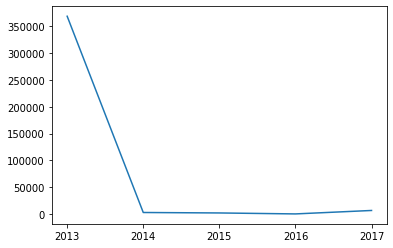

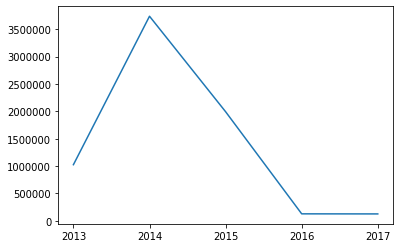

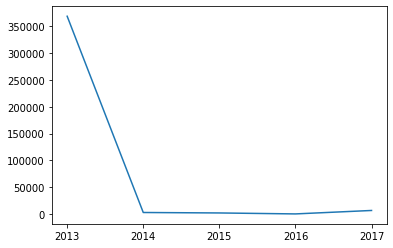

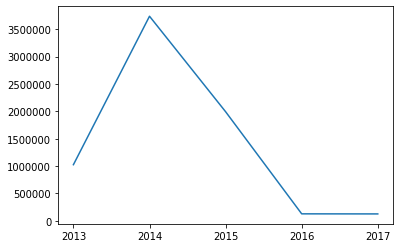

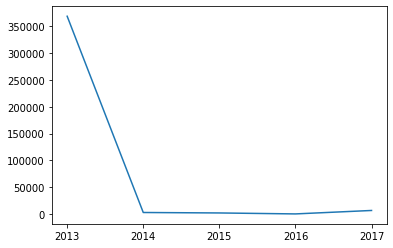

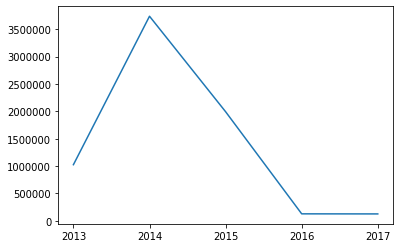

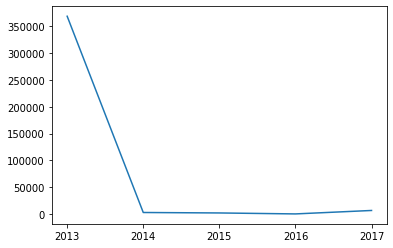

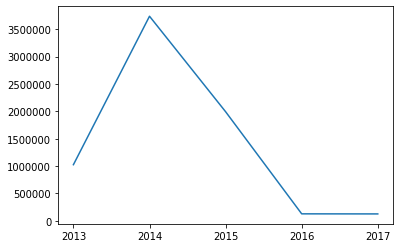

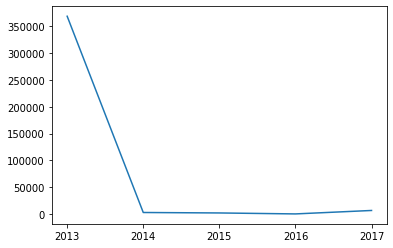

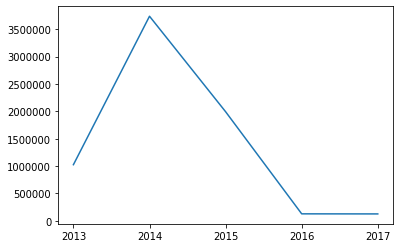

In [352]:
u_seg_df = u_seg_df.sort_values('Year')
# Convert the Month into integer
u_seg_df['total_amt'] = 0
for i in range(1, len(u_seg_df)):
    u_seg_df['Month'][i] = int(u_seg_df['Month'][i])
    # Create total amount column by multiplying per unit cost.
    # with toatl orders.
    u_seg_df['total_amt'][i] = int(u_seg_df['Orders'][i]) * float(u_seg_df['Sales'][i])

# Create new aggegate dataframe with pertinent columns.
#cust_target_agg_df = pd.DataFrame(columns = ['Year', 'id', 'amount'])
u_ag_df = u_seg_df.groupby(['Year', 'CustomerID']).total_amt.sum().to_frame('Total_Sale').reset_index()

# Plot to understand the trend
for customers in u_ag_df['CustomerID']:
    financial_year = []
    total_sale = []
    for i in range(0, len(u_ag_df)):
        if u_ag_df['CustomerID'][i] == customers:
            financial_year.append(u_ag_df['Year'][i])
            total_sale.append(u_ag_df['Total_Sale'][i])
    plot(financial_year, total_sale)
    show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


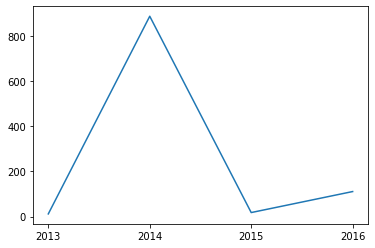

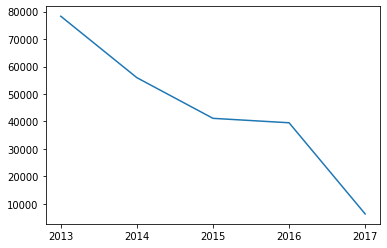

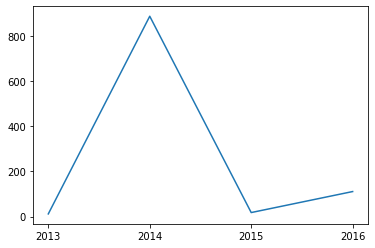

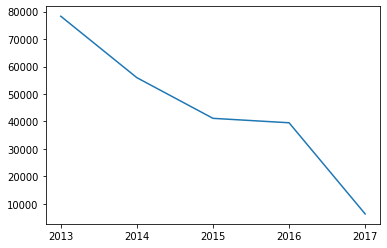

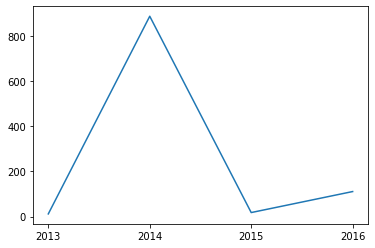

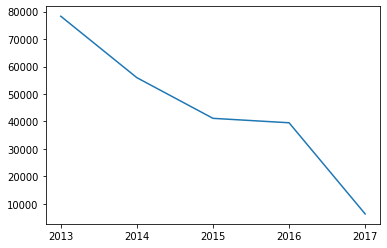

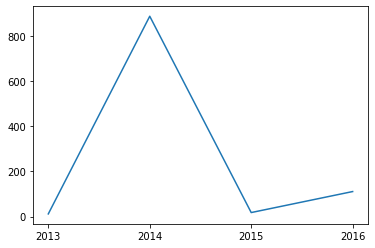

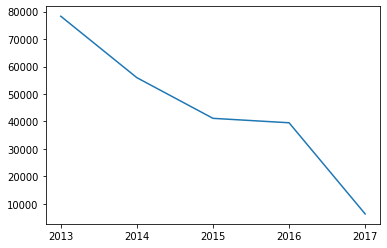

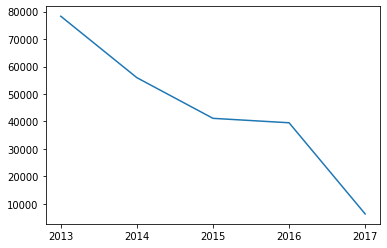

In [353]:
a_seg_df = a_seg_df.sort_values('Year')
# Convert the Month into integer
a_seg_df['total_amt'] = 0
for i in range(1, len(a_seg_df)):
    a_seg_df['Month'][i] = int(a_seg_df['Month'][i])
    # Create total amount column by multiplying per unit cost.
    # with toatl orders.
    a_seg_df['total_amt'][i] = int(a_seg_df['Orders'][i]) * float(a_seg_df['Sales'][i])

# Create new aggegate dataframe with pertinent columns.
#cust_target_agg_df = pd.DataFrame(columns = ['Year', 'id', 'amount'])
a_ag_df = a_seg_df.groupby(['Year', 'CustomerID']).total_amt.sum().to_frame('Total_Sale').reset_index()

# Plot to understand the trend
for customers in a_ag_df['CustomerID']:
    financial_year = []
    total_sale = []
    for i in range(0, len(a_ag_df)):
        if a_ag_df['CustomerID'][i] == customers:
            financial_year.append(a_ag_df['Year'][i])
            total_sale.append(a_ag_df['Total_Sale'][i])
    plot(financial_year, total_sale)
    show()

In [338]:
u_seg_df['Channel'].unique()

array(['Offline'], dtype=object)

In [337]:
a_seg_df['Channel'].unique()

array(['Offline'], dtype=object)

In [340]:
trans_no_phl_df['Channel'].unique()

array(['eCommerce', 'Offline'], dtype=object)